house_tree_image_pixel_data max 255
house_tree_image_pixel_data min 0


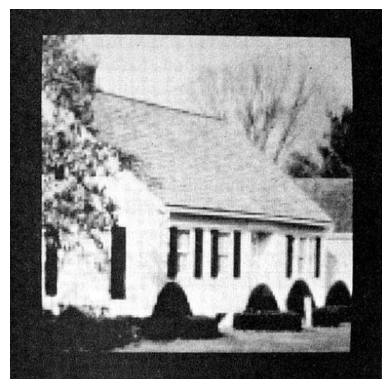

In [56]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
image = Image.open("house_and_tree.jpg").convert("L")

# Convert the image to a NumPy array
house_tree_image_pixel_data = np.array(image)

print("house_tree_image_pixel_data max", house_tree_image_pixel_data.max())
print("house_tree_image_pixel_data min", house_tree_image_pixel_data.min())

# Display the image using Matplotlib
plt.imshow(house_tree_image_pixel_data, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

In [58]:
# When applying dilation, the algorithm typically sets a pixel to white (255) if any pixel in its neighborhood (defined by the kernel) 
# is white. If even one pixel in the 3x3 region (for example) is white, then that central pixel becomes white in the dilated image. 
# This operation "expands" the white regions, making the boundaries of white areas grow outward. 
# Even if only a small part of the neighborhood is white, the central pixel is turned white, leading to the dilation
# of the white regions in the image.

def binary_dilation(binary_image):
    rows, cols = binary_image.shape
    
    dilated_image = np.zeros_like(binary_image)
    
    kernel_size = 3 
    
    # Iterate over the image (excluding borders)
    for i in range(kernel_size, rows - kernel_size):
        for j in range(kernel_size, cols - kernel_size):
            region = binary_image[i - kernel_size:i + kernel_size + 1, j - kernel_size:j + kernel_size + 1]
            if np.any(region == 255):
                dilated_image[i, j] = 255

    return dilated_image


In [60]:
# When applying erosion, the algorithm typically sets a pixel to white only if every pixel in its neighborhood (defined by the kernel) 
# is white. If even one pixel in the 3x3 region (for example) is black, then that central pixel becomes black in the eroded image.

def binary_erosion(binary_image):
    rows, cols = binary_image.shape
    
    eroded_image = np.zeros_like(binary_image)
    
    kernel_size = 3 
    
    # Iterate over the image (excluding borders)
    for i in range(kernel_size, rows - kernel_size):
        for j in range(kernel_size, cols - kernel_size):
            region = binary_image[i - kernel_size:i + kernel_size + 1, j - kernel_size:j + kernel_size + 1]            
            if np.all(region == 255):
                eroded_image[i, j] = 255

    return eroded_image


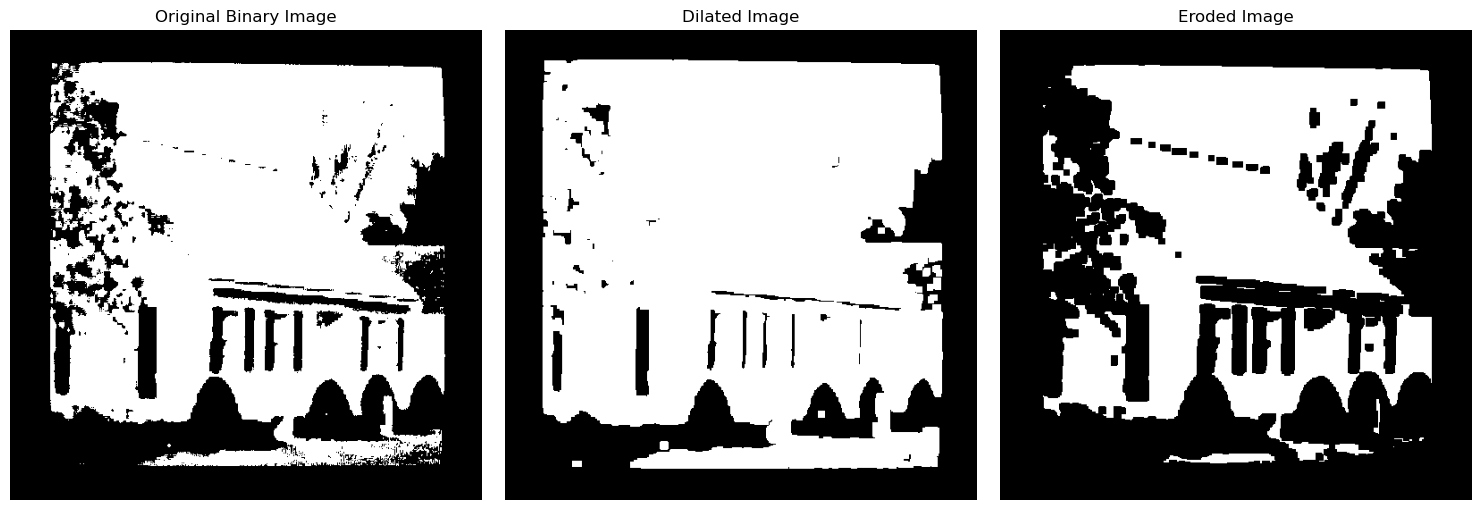

In [62]:
# Dilation (Growing or "Making it Bigger", adding more white space) => Vector Addition
# Dilation is a morphological operation that "grows" or "expands" the boundaries of the foreground (usually white) regions in a binary image. It adds pixels to the edges of objects.

# Erosion (Shrinking or "Making it Smaller", less white space) => Vector Subtraction
# Erosion is the opposite of dilation. It "shrinks" or "erodes" the boundaries of the foreground regions in a binary image by removing pixels along the edges.

# When applying erosion, the algorithm typically sets a pixel to white only if every pixel in its neighborhood (defined by the kernel) 
# is white. If even one pixel in the 3x3 region (for example) is black, then that central pixel becomes black in the eroded image.

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# from scipy.ndimage import binary_dilation, binary_erosion

THRESHOLD = 128

# Convert the grayscale image to a binary image using a threshold.
binary_image = np.zeros_like(house_tree_image_pixel_data, dtype=np.uint8)

for i in range(house_tree_image_pixel_data.shape[0]): 
    for j in range(house_tree_image_pixel_data.shape[1]):
        if house_tree_image_pixel_data[i, j] > THRESHOLD:
            binary_image[i, j] = 255 
        else:
            binary_image[i, j] = 0 

# Apply binary dilation (this "grows" the white regions)
dilated_image = binary_dilation(binary_image)

# Apply binary erosion (this "shrinks" the white regions)
eroded_image = binary_erosion(binary_image)

# Plot the original binary image, dilated image, and eroded image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap='gray')
plt.title("Original Binary Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(dilated_image, cmap='gray')
plt.title("Dilated Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(eroded_image, cmap='gray')
plt.title("Eroded Image")
plt.axis('off')

plt.tight_layout()
plt.show()


0.0
1076.0


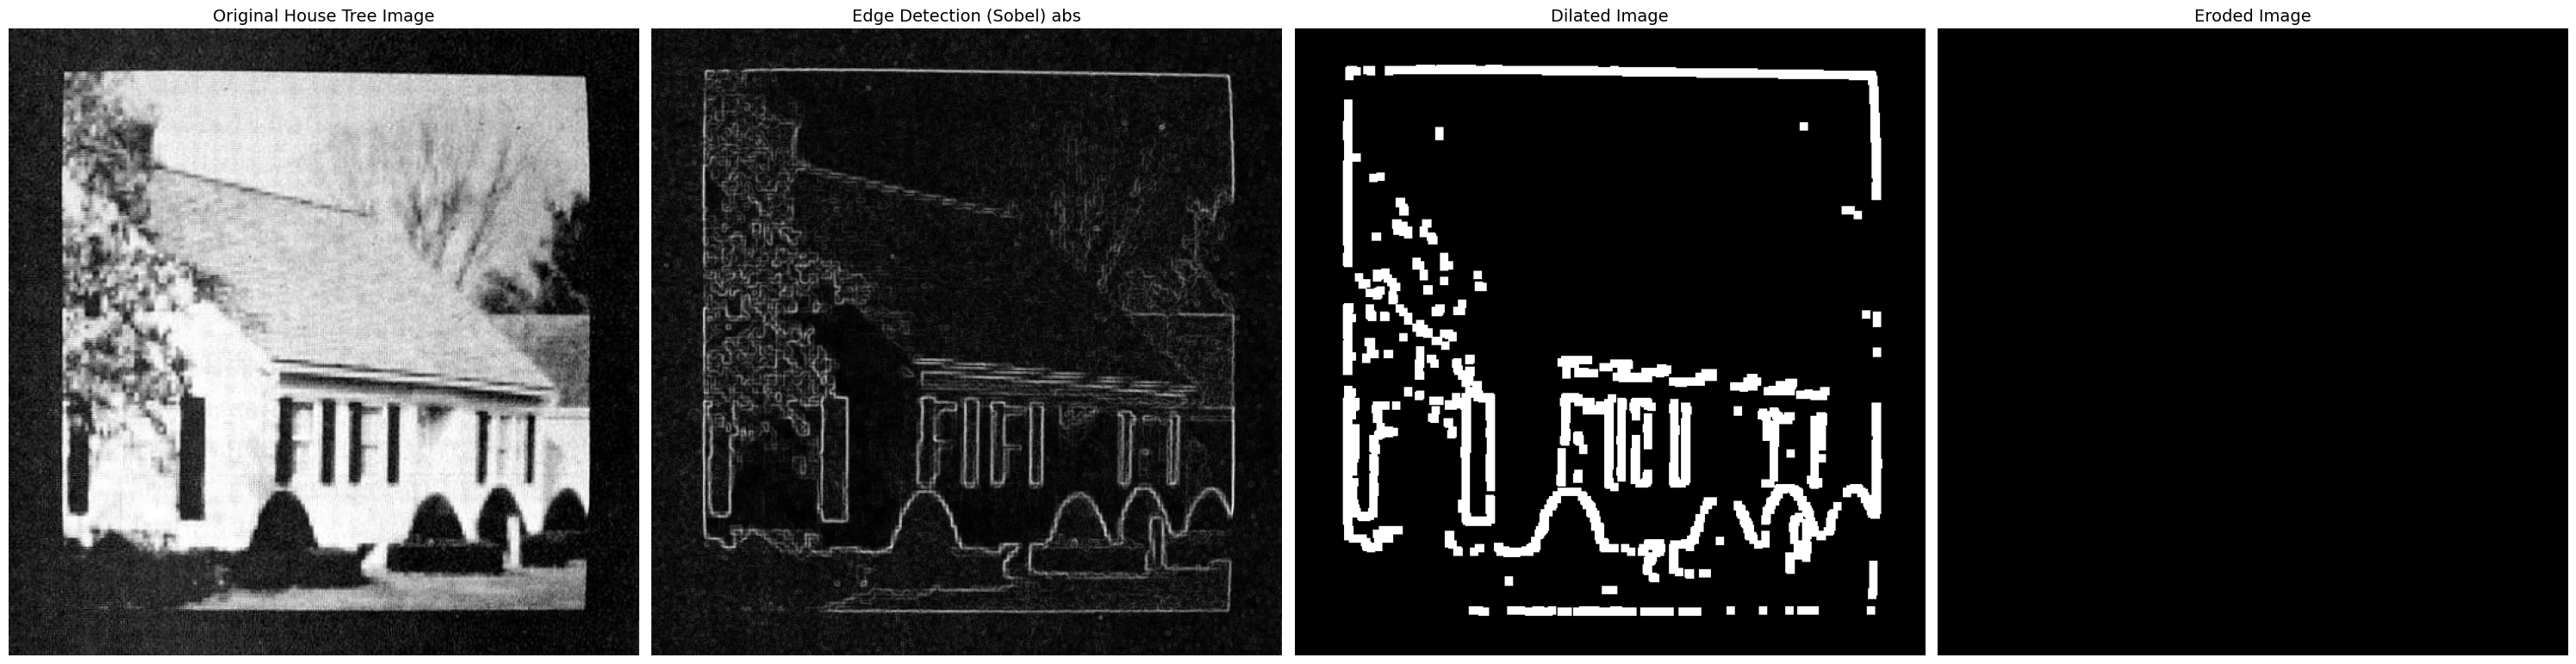

In [68]:
# Using Sobel Operator.
# Here I am not padding, and the convolution only occurs on the valid regions.
# So the size of the image decreases

import numpy as np
import matplotlib.pyplot as plt

# Sobel kernels for X and Y direction
sobel_x_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

def convolve(image, kernel):
    # Get dimensions of the image and the kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Prepare an empty output image with 'valid' size 
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    
    output = np.zeros((output_height, output_width))

    # Iterate over every pixel of the original image (valid region)
    for i in range(output_height):
        for j in range(output_width):
            region = image[i:i + kernel_height, j:j + kernel_width]
            
            # Perform element-wise multiplication and sum the result
            output[i, j] = np.sum(region * kernel)
    
    return output

sobel_x = convolve(house_tree_image_pixel_data, sobel_x_kernel)

# numpy converts the unit to float while using np.sum(region * kernel)
sobel_y = convolve(house_tree_image_pixel_data, sobel_y_kernel)

# Calculate gradient magnitude using absolute values
edge_image_abs_sobel = np.abs(sobel_x) + np.abs(sobel_y)


print(edge_image_abs_sobel.min())
print(edge_image_abs_sobel.max())

# Normalize the image so that it corectly applies the binarization. We want the image to be in the range of (0 to 255)
normalized_edge_image_sobel = (edge_image_abs_sobel - edge_image_abs_sobel.min()) / (edge_image_abs_sobel.max() - edge_image_abs_sobel.min()) * 255

# Global Thresholding or Binarization
THRESHOLD = 128

# Convert the grayscale image to a binary image using a threshold.
binary_image = np.zeros_like(normalized_edge_image_sobel, dtype=np.uint8)

for i in range(normalized_edge_image_sobel.shape[0]): 
    for j in range(normalized_edge_image_sobel.shape[1]):
        if normalized_edge_image_sobel[i, j] > THRESHOLD:
            binary_image[i, j] = 255 
        else:
            binary_image[i, j] = 0 

# Apply binary dilation (this "grows" the white regions)
dilated_image = binary_dilation(binary_image)

# Apply binary erosion (this "shrinks" the white regions)
eroded_image = binary_erosion(binary_image)

fig, axes = plt.subplots(1, 4, figsize=(30, 8))  # Add one more axis for the additional plots

axes[0].imshow(house_tree_image_pixel_data, cmap="gray")
axes[0].set_title("Original House Tree Image", fontsize=14)

axes[1].imshow(edge_image_abs_sobel, cmap="gray")
axes[1].set_title("Edge Detection (Sobel) abs", fontsize=14)

axes[2].imshow(dilated_image, cmap="gray")
axes[2].set_title("Dilated Image", fontsize=14)

axes[3].imshow(eroded_image, cmap="gray")
axes[3].set_title("Eroded Image", fontsize=14)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [69]:
# Dilution (Dilation) and Erosion are fundamental operations in morphological image processing, and they have several 
# real-world applications across various fields. These operations are particularly useful in tasks related to binary images 
# (images with only two pixel values, typically black and white), often used in computer vision, medical imaging, and remote sensing. 

# Real-World Uses of Dilation (Dilution)
# Object Detection and Enhancement:

# Dilation is often used to connect broken parts of objects or structures. In object detection, after edge detection or thresholding,
# dilation can help fill gaps in detected objects, making them more continuous and complete.
# Example: License plate recognition — Dilation helps merge fragmented parts of letters/numbers to form legible characters.
# Image Filling and Boundary Extension:

# Dilation is used to fill holes in objects or to extend the boundaries of objects in binary images.
# Example: Fingerprint analysis — Dilation can help fill small gaps or breaks in fingerprint ridges, improving the matching process.
# Noise Removal (Post-Processing):

# Dilation can also be used to remove small noise or isolated black pixels in a binary image by expanding the white regions and 
# eliminating tiny isolated points.
# Example: Document scanning — After thresholding, dilation can clean up scanned text or images by expanding letters or erasing 
# small specks of ink.
# Feature Extraction in Geospatial Imaging:

# Dilation is used to enlarge features like roads or buildings in satellite images, making them more visible for analysis.
# Example: Land Use Classification — In geographic information systems (GIS), dilation is used to enhance features such as 
# roads, rivers, or urban areas to make them more easily identifiable.

# Real-World Uses of Erosion
# Noise Removal and Small Object Removal:

# Erosion is typically used to remove small noise or isolated white pixels. This operation is useful in cleaning up binary 
# images by shrinking the white regions and removing small irrelevant features.
# Example: Medical Imaging (X-rays, CT scans) — Erosion is used to remove small imperfections or noise in the medical scans, 
# focusing more on relevant structures like bones or organs.
# Separation of Connected Objects:

# Erosion helps separate connected objects in binary images. If two objects are touching, erosion can shrink them and create a gap
# between them, which is useful for further analysis.
# Example: Cell analysis — In microscopic images of biological cells, erosion can separate touching cells to identify them individually.
# Edge Detection and Boundary Refinement:

# Erosion can refine edges and boundaries of objects in an image by shrinking the boundaries of white regions, making the objects appear
# smaller.
# Example: Roads in satellite images — Erosion is used to refine and narrow the width of roads in satellite imagery, 
# making it easier to analyze or detect road features.
# Character Recognition and Document Processing:

# In Optical Character Recognition (OCR), erosion is used to remove extraneous pixels from characters, such as small dots or
# lines that are not part of the letterforms, improving recognition accuracy.
# Example: Invoice Processing — After detecting text from scanned invoices, erosion can be used to clean the characters,
# making the text clearer for the OCR algorithm.